<a href="https://colab.research.google.com/github/nickwan/nwds-stream-notebooks/blob/main/aella_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# aella datasets  
https://knowingless.com/raw-data/  

In [1]:
!pip install adjustText
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from adjustText import adjust_text

In [3]:
project_dir = 'drive/My Drive/aella-data'

In [4]:
os.listdir(project_dir)

['kinkinterestpublic.csv', 'taboo-ratings.csv']

In [5]:
taboo = pd.read_csv(f'{project_dir}/taboo-ratings.csv')
taboo.shape

/tmp/ipython-input-2231528155.py:1: DtypeWarning: Columns (2,19,231,288,289,294,297,300,303,305,308) have mixed types. Specify dtype option on import or set low_memory=False.
  taboo = pd.read_csv(f'{project_dir}/taboo-ratings.csv')


(4514, 314)

In [6]:
taboo.columns.values

array(['Run', 'Program Version', 'User', 'Time Started (UTC)',
       'Time Finished (UTC)', 'Minutes Spent', 'Position', 'Points',
       'arousalScale', 'Your age? (rkkox57)', 'selfage',
       'Which category fits you best? (4790ydl)', 'biomale', 'gendermale',
       'cis', 'gendered', 'You got to this survey from: (mpjxl34)',
       'Is this your first time taking the survey? (o8uwpe)', 'firsttime',
       'Randomize (ghojbjt)', 'sexual teasing (vdrdwok)', 'teasing',
       'vaginal sex (with a penis or penile-toy) (nejpuy2)', 'normalsex',
       'anal sex (o282uc7)', 'analsex', 'prepubescent children (53ggvq3)',
       'pedophilia', 'having sex with an anonymous stranger (4296bnp)',
       'anonsex', 'CGL (caregiver/little) dynamics (20uachz)', 'cgl',
       'specific sensory textures (38zk5a)', 'textures',
       'sexual scenarios involving specific roles (like secretaries, nurses, catgirls, etc.) (4odx2pm)',
       'roles',
       'sexual scenarios involving a specific state of 

In [8]:
df = pd.read_csv(f'{project_dir}/kinkinterestpublic.csv')
df = df.drop('Unnamed: 0',axis=1)
df = df.loc[df['selfage']>=18].copy()
df = df.loc[df['selfage']<=df['selfage'].quantile(.99)]
col = np.random.choice(df.columns.values)
person_cols = ['Minutes Spent', 'gendermale', 'biomale', 'selfage', 'cis', 'n_kinks']
kink_cols = [x for x in df.columns.values if x not in person_cols]
df['n_kinks'] = df.loc[:, kink_cols].replace(0, np.nan).count(axis=1)
df.shape

(57300, 133)

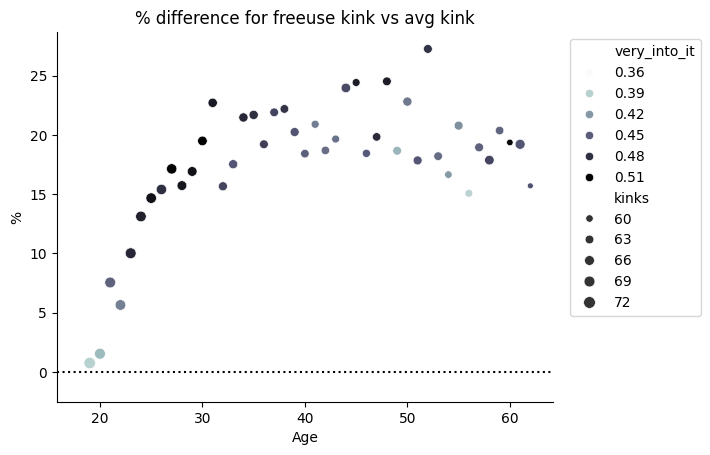

In [9]:
col = np.random.choice(df.columns.values)
person_cols = ['Minutes Spent', 'gendermale', 'biomale', 'selfage', 'cis', 'n_kinks']
kink_cols = [x for x in df.columns.values if x not in person_cols]
df_plt = df.loc[:, ['selfage']+kink_cols].replace(0,np.nan).groupby('selfage', as_index=False).mean()
_df_plt = df.loc[df[col]>0, ['selfage', 'n_kinks']].groupby('selfage', as_index=False).mean()
df_plt = pd.melt(df_plt,id_vars='selfage')
_df_plt = pd.melt(_df_plt,id_vars='selfage', value_name='kinks')
df_plt = df_plt.merge(_df_plt.drop('variable',axis=1))
df_plt_base = df.loc[:, ['selfage']+kink_cols].replace(0,np.nan).groupby('selfage', as_index=False).mean()
df_plt_base['avg'] = df_plt_base.loc[:, kink_cols].mean(axis=1)
df_plt_base.loc[:, ['selfage','avg']]
df_plt = df_plt.merge(df_plt_base)
df_plt['%diff'] = ((df_plt['value'].sub(df_plt['avg'])).div(df_plt['avg'])).mul(100)
_df_plt1 = df.loc[df[col]>3, ['selfage', col]].groupby('selfage', as_index=False).count()
_df_plt2 = df.loc[df[col]>0, ['selfage', col]].groupby('selfage', as_index=False).count()
_df_plt1 = _df_plt1.merge(_df_plt2, on=['selfage'])
_df_plt1[col] = _df_plt1[f'{col}_x'].div(_df_plt1[f'{col}_y'])
df_plt = df_plt.merge(_df_plt1.loc[:, ['selfage',col]].rename(columns={col:'very_into_it'}))
sns.scatterplot(data=df_plt.loc[df_plt['variable']==col], x='selfage', y='%diff',
                hue='very_into_it', palette='bone_r', size='kinks')
plt.axhline(0, ls=':', c='k')
plt.title(f"% difference for {col} kink vs avg kink")
sns.despine()
plt.xlabel('Age')
plt.ylabel('%')
plt.legend(bbox_to_anchor=(1.02,1),loc=2)
plt.show()

In [10]:
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, mean_squared_error
import catboost as cb

person_cols = ['Minutes Spent', 'gendermale', 'biomale', 'selfage', 'cis', 'n_kinks']
kink_cols = [x for x in df.columns.values if x not in person_cols]
target = 'armpits'
target_clf = f'{target}%'
# feats = ['gendermale', 'biomale', 'selfage', 'cis', 'n_kinks']+kink_cols
feats = ['gendermale', 'biomale', 'selfage', 'cis', 'n_kinks']+[x for x in kink_cols if x!=target]


model_data = df.loc[:, feats+[target]].fillna(-1)
model_data[f'{target}%'] = 0
model_data['model2'] = 0
model_data.loc[model_data[target]>0,f'{target}%'] = 1
model_data.loc[model_data[f'{target}']>0, 'model2'] = 1

folds = 3
kf = KFold(folds, shuffle=True)
clf = pd.Series()
score = pd.Series()
for train_idx, test_idx in tqdm(kf.split(model_data), total=folds):
  train = model_data.iloc[train_idx]
  test = model_data.iloc[test_idx]
  model = cb.CatBoostClassifier(learning_rate=0.001, verbose=False)
  model.fit(train.loc[:, feats], train[target_clf])
  s = pd.DataFrame(model.predict_proba(test.loc[:, feats]), index=test.index)[1]
  clf = pd.concat([clf,s])

  train2 = train.loc[train['model2']==1].copy()
  # test2 = test.loc[test['model2']==1].copy()
  model = cb.CatBoostRegressor(learning_rate=0.001, verbose=False)
  model.fit(train2.loc[:, feats], train2[target])
  s = pd.Series(model.predict(test.loc[:, feats]), index=test.index)
  score = pd.concat([score,s])

model_data[f'{target}%_pred'] = clf
model_data[f'{target}_pred'] = score



  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipython-input-1360643427.py:29: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  clf = pd.concat([clf,s])
/tmp/ipython-input-1360643427.py:36: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  score = pd.concat([score,s])


In [11]:
[
    log_loss(model_data[f'{target}%'],model_data[f'{target}%_pred']),
    mean_squared_error(model_data[f'{target}'],model_data[f'{target}_pred'])**0.5,
]


[0.40294290457779036, 2.2303691369278]

,armpits%_pred
count,57300.000000
mean,0.295910
std,0.198246
min,0.063421
25%,0.095841
50%,0.257669
75%,0.442426
max,0.807303


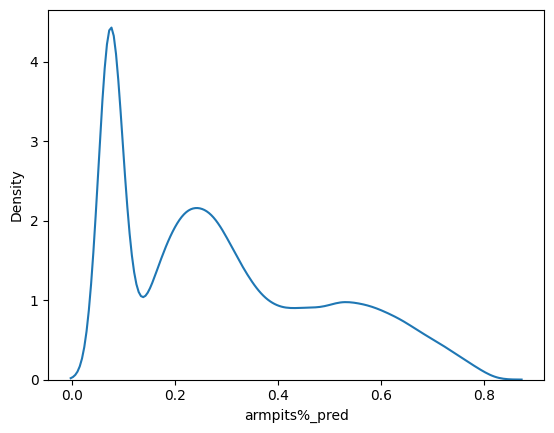

In [12]:
sns.kdeplot(model_data[f"{target}%_pred"])
model_data[f"{target}%_pred"].describe()

,armpits_pred
count,11376.000000
mean,2.378737
std,0.377257
min,1.924203
25%,2.083559
50%,2.281280
75%,2.566189
max,3.876083


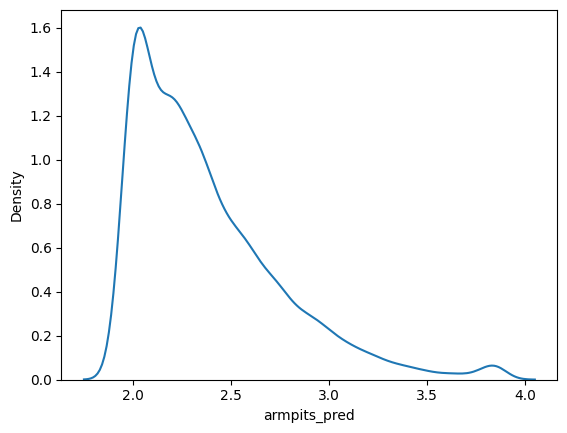

In [13]:
sns.kdeplot(model_data.loc[model_data[f'{target}%_pred']>.5, f'{target}_pred'])
model_data.loc[model_data[f'{target}%_pred']>.5, f'{target}_pred'].describe()

In [14]:
ranks = model_data.loc[model_data[f'{target}%_pred']>.5, kink_cols].mean().sort_values(ascending=False)
ranks[ranks>0].head(50)

,0
femininity,4.366297
sensuality,4.048611
blowjobs,4.042458
makeouts,4.023119
cunnilingus,3.870165
teasing,3.870165
lips,3.815225
skirts,3.769691
toys,3.657437
romance,3.640032


In [15]:
ranks = model_data.loc[(model_data[f'{target}%_pred']>.5) & (model_data[f'{target}_pred']>3), kink_cols].mean().sort_values(ascending=False)
ranks[ranks>0].head(50)

,0
smells,4.716867
femininity,4.595181
feet,4.539759
teasing,4.525301
blowjobs,4.524096
analsex,4.481928
makeouts,4.443373
cunnilingus,4.430120
lips,4.408434
sensuality,4.406024
